### SOLID: a Framework of Synergizing Optimization and Large Language Models for Intelligent Decision-Making
Authors: Yinsheng Wang, Tario You, Léonard Boussioux

In this model, we build two agents to decide an investment strategy for a portfolio of stocks.
For simplicity, we assume that the portfolio consists of 4 stocks: NVDA, GOOG, MSTR, and SMCI.
The first agent is a mean-variance optimization model. It aims to minimize the portfolio variance while achieving a target return.
The second agent is a GPT-based Language Model. Through prompt-based learning, it aims to generate a portfolio strategy that maximizes the portfolio return.
The two agents will communicate with each other to reach a consensus on the portfolio strategy, i.e., the portfolio weights for the two stocks.

#### Import necessary libraries

In [1]:
from openai import OpenAI
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv
import matplotlib.colors as mcolors
from IPython.display import display

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "WMT"] # 1
# tickers = ["AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 2
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 3
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE", "V"] # 4
# tickers = ["AAPL", "MSFT", "NVDA", "GOOGL", "META", "JPM", "XOM", "UNH", "WMT", "HD", "CAT", "PLD", "NEE", "V", "AMD"] # 6% better
# tickers = ["MS", "BAC", "CVX", "PFE", "PEP", "COST", "NFLX", "INTC", "LMT", "CSCO", "AXP", "AMZN", "TMUS", "TM", "DUK"]
# tickers = ["CVX", "PFE", "NFLX", "LMT", "TM", "PLTR", "OKTA", "MAR", "MCD", "SBUX", "EBAY", "MRNA", "BHP", "TGT", "EOG"]
tickers = [
    'NVDA', 'AMD', 'MSFT', 'AAPL', 'INTC', 'PLTR',  # Technology
    'TSLA', 'AMZN', 'SBUX', 'TGT', 'NFLX', 'MCD',  # Consumer Discretionary
    'HOOD', 'BAC', 'JPM', 'MS', 'V', 'SCHW',  # Financials
    'ZG', 'PLD', 'WELL', 'SPG', 'PSA', 'EQR',  # Real Estate
    'GEV', 'XOM', 'DUK', 'NEE', 'EOG', 'SLB',  # Energy
    'TEM', 'UNH', 'PFE', 'MRNA', 'ABBV', 'MDT',  # Healthcare
    'CAT', 'BA', 'LMT', 'DE', 'GD', 'HON',  # Industrials
    'PCT', 'NEM', 'LIN', 'APD', 'FCX', 'MLM',  # Materials
    'GOOG', 'TMUS', 'META', 'DIS', 'VZ', 'CMCSA',  # Communication Services
    'COST', 'PEP', 'WMT', 'KO', 'PG', 'MO'  # Consumer Staples
]

stock_categories = [
    "Technology",
    "Consumer Discretionary",
    "Finance",
    "Real Estate",
    "Energy", 
    "Healthcare",
    "Industrial",
    "Material",
    "Communication",
    "Consumer Staples"
]

In [2]:
# CHANGE THESE!!
appendage = "nvda60_prompt"
iteration = 3

# always just appends
init_news_path = f"assets/init_news_reports.json"
stock_data_path = f"assets/stock_data.json"

pft_path = f"assets/portfolio_{appendage}.csv"
stock_price_history_image_path = f'figures/stock_price_history_{appendage}.png'

grid_image_path = f'assets/output_{appendage}_{iteration}.png'
weights_coord_path = f"assets/weights_coord_{appendage}_{iteration}.json"
weights_llm_path = f"assets/weights_llm_{appendage}_{iteration}.json"
weights_opt_path = f"assets/weights_opt_{appendage}_{iteration}.json"
pft_value_over_time_path = f'figures/pft_value_over_time_{appendage}_{iteration}.png'
heatmap_path = f"figures/heatmap_{appendage}_{iteration}.png"

rerun_opt, rerun_llm, rerun_coord = False, False, False

#### Functions to save data locally

In [3]:
def save_data(data, file_path=stock_data_path):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path=stock_data_path):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path=stock_data_path
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] (I'll provide you the stock ticker) from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary if tickers dont exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                # print(f'patched: month {months[i]}\t{ticker}')
            # else:
                # print(f'skipping: {ticker}')
            
            # save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

#### Using Perplexity to gather news about the tickers

In [4]:
client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data = [
    # Jan
    # {
    #     "MSFT":{
    #         "news": "yay", # news for all of Jan
    #         "price": 20 # last day's closing price - Jan 31
    #     }
    # }
]

#### Loading the S&P 500 tickers

In [5]:
file_path = 'assets/constituents.csv'
data = pd.read_csv(file_path)
constituents = data['Symbol'].tolist()

# constituents

#### Patching data for tickers

In [6]:
patch_data(tickers)
# S&P 500: patch_data(constituents)

Data loaded from assets/stock_data.json


100%|██████████| 60/60 [00:00<00:00, 592137.04it/s]

Data saved to assets/stock_data.json


#### Initial stock introductions

In [7]:
def load_init_news_reports():
    with open("assets/init_news_reports.json", "r") as f:
        stock_reports = json.load(f)
    return stock_reports

def save_init_news_reports(init_news_reports):
    with open("assets/init_news_reports.json", "w") as f:
        json.dump(init_news_reports, f, indent=4)

def patch_init_news_reports():
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
    
    init_news_reports = load_init_news_reports()
    for ticker in tickers:
        if ticker not in init_news_reports:

            messages = [
                {
                    "role": "system",
                    "content": "You analyze and summarize companies."
                },
                {
                    "role": "user",
                    "content": f"Give me a 100 word summary about the stock ticker {ticker}"
                }
            ]

            response = client.chat.completions.create(
                model="llama-3.1-sonar-large-128k-online",
                messages=messages,
            ) 

            init_news_reports[ticker] = response.choices[0].message.content

    save_init_news_reports(init_news_reports)

patch_init_news_reports()

#### Get ticker prices

In [8]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        
        missing_tickers = []
        missing_indices = []
        for i, ticker in enumerate(tickers):
            ticker_data = data_loaded[month-1][ticker]
            if "price" not in ticker_data:
                missing_tickers.append(ticker)
                missing_indices.append(i)
            else:
                if np.isnan(ticker_data['price']):
                    missing_tickers.append(ticker)
                    missing_indices.append(i)

        if missing_indices:
            prices = get_stock_price(missing_tickers, datetime_obj)
            if type(prices) != type([]):
                prices = [prices]

            for i, (ticker, j) in enumerate(zip(missing_tickers, missing_indices)):
                data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

# get_stock_price('ZG', datetime.datetime(2024, 1, get_last_trading_day_of_month(2024, 1)))

data_loaded = load_data()
get_closing_prices(data_loaded)

Data loaded from assets/stock_data.json
Data saved to assets/stock_data.json


#### Getting the tickers' historical prices for the optimizer
This is not just closing price at the end of each month like above, it's the entire data for a year

In [9]:
leo_key = os.getenv("CHAT")

client = OpenAI(
    api_key=leo_key,
)

def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv(pft_path, index=True)
portfolio = pd.read_csv(pft_path, parse_dates=True, index_col="Date")

[*********************100%%**********************]  60 of 60 completed


#### Historical ticker prices

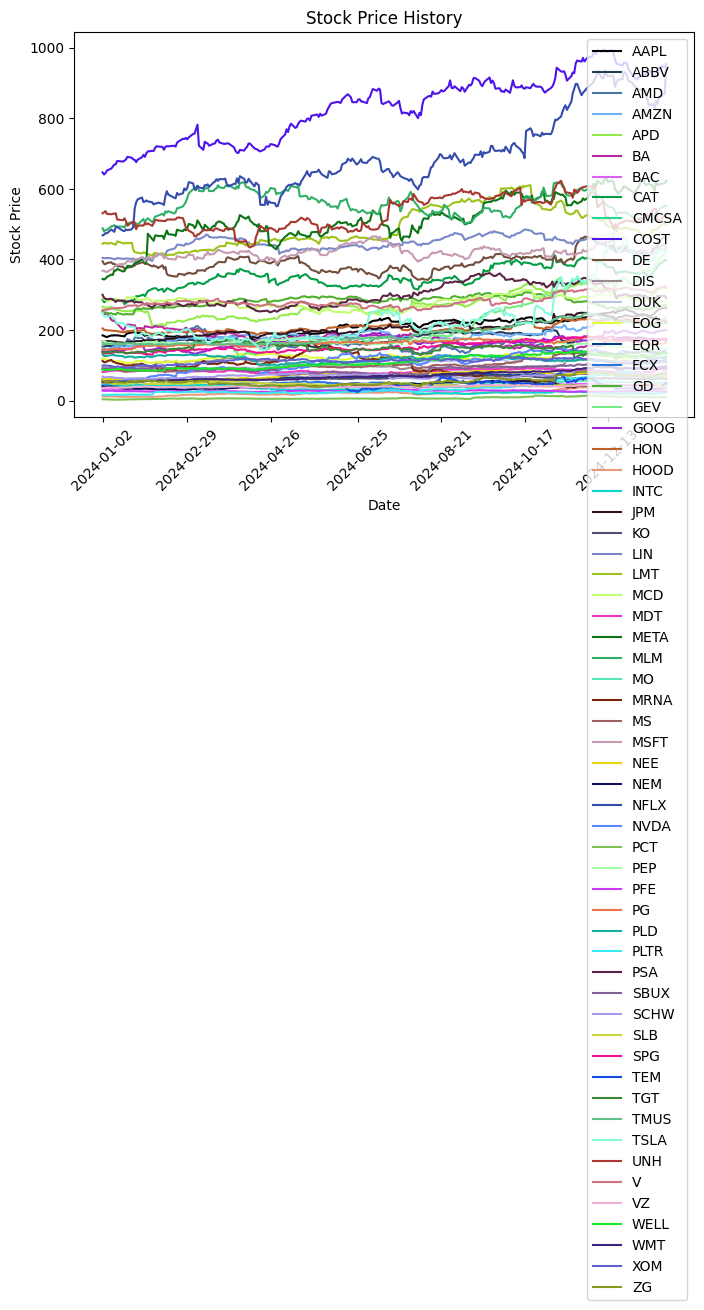

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

df = portfolio

# Function to generate a list of colors by iterating through RGB values
def generate_colors(n_colors):
    colors = []
    for i in range(n_colors):
        r = (i * 37) % 256 / 255.0  # Example formula for varying red
        g = (i * 59) % 256 / 255.0  # Example formula for varying green
        b = (i * 83) % 256 / 255.0  # Example formula for varying blue
        colors.append((r, g, b))
    return colors

# Generate unique colors based on the number of columns
colors = generate_colors(len(df.columns))

# Plot
plt.figure(figsize=(8, 5))

# Plot each column with a unique color
for idx, column in enumerate(df.columns):
    plt.plot(df.index, df[column], label=column, color=colors[idx])

# Formatting the x-axis
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price History")
plt.legend()

tick_indices = df.index[::40]  # Select every 60th index
plt.xticks(tick_indices, [date.strftime('%Y-%m-%d') for date in tick_indices], rotation=45)

plt.tight_layout()

# Save the plot
plt.savefig(stock_price_history_image_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()


Expected annual return: 41.0%
Annual volatility: 14.8%
Sharpe Ratio: 2.63


AAPL     0.204683
ABBV     0.118622
AMD      0.525353
AMZN     0.353454
APD      0.202512
BA       0.276162
BAC      0.309608
CAT      0.380751
CMCSA    0.225297
COST     0.200151
DE       0.262514
DIS      0.214964
DUK      0.103430
EOG      0.161856
EQR      0.230799
FCX      0.384469
GD       0.190559
GEV      0.580082
GOOG     0.274644
HON      0.204306
HOOD     0.824460
INTC     0.649952
JPM      0.300550
KO       0.070175
LIN      0.181641
LMT      0.083877
MCD      0.151072
MDT      0.178811
META     0.292407
MLM      0.323596
MO       0.100110
MRNA     0.508709
MS       0.379350
MSFT     0.247269
NEE      0.190520
NEM      0.293460
NFLX     0.273641
NVDA     0.460794
PCT      0.787617
PEP      0.072812
PFE      0.161333
PG       0.056588
PLD      0.324758
PLTR     0.704708
PSA      0.235757
SBUX     0.284335
SCHW     0.251082
SLB      0.289222
SPG      0.290321
TEM      1.721938
TGT      0.260523
TMUS     0.126172
TSLA     0.697667
UNH      0.126529
V        0.196214
VZ       0

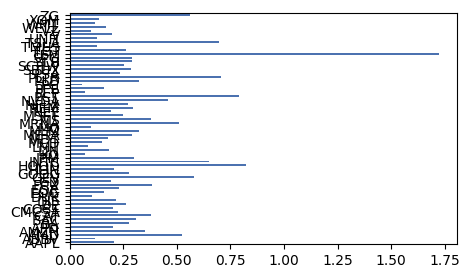

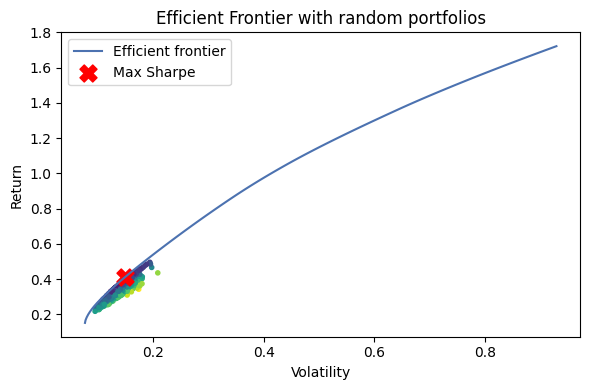

In [11]:
sample_cov = risk_models.sample_cov(portfolio, frequency=252)

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)

mu.plot.barh(figsize=(5, 3))

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(6, 4))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()

mu

#### Generate initial stock info

In [12]:
with open(init_news_path, "r") as f:
    stock_reports = json.load(f)
stock_reports

{'NVDA': "NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.",
 'GOOG': "Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mountain View, California. The company's primary revenue 

In [13]:
# brief stock introductions obtained from Perplexity.ai
def generate_data_summary(reports):
    summary = f"Recent reports indicate:\n"
    for ticker in tickers:
        report = reports[ticker]
        summary += f"For {ticker}:\n{report}\n\n"
    return summary

initial_stock_info = generate_data_summary(stock_reports)

#### Dynamic YF stock data storage
pre download the data

In [14]:
# get the data
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2025, 1, 1)
prices = yf.download(tickers, start=start_date, end=end_date)
portfolio = prices["Adj Close"].dropna(how="all")
portfolio.to_csv(pft_path, index=True)

[**********************58%%**                    ]  35 of 60 completed

KeyboardInterrupt: 

[**********************62%%****                  ]  37 of 60 completed

[**********************93%%*******************   ]  56 of 60 completed

In [297]:
# demonstration of the data being got
portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
start_date = datetime.datetime(2023, 12, 1)
end_date = datetime.datetime(2023, 12, get_last_trading_day_of_month(2023, 12))
df_subset = portfolio.loc[start_date:end_date]
df_subset

,AAPL,ABBV,AMD,AMZN,APD,BA,BAC,CAT,CMCSA,COST,DE,DIS,DUK,EOG,EQR,FCX,GD,GEV,GOOG,HON,HOOD,INTC,JPM,KO,LIN,LMT,MCD,MDT,META,MLM,MO,MRNA,MS,MSFT,NEE,NEM,NFLX,NVDA,PCT,PEP,PFE,PG,PLD,PLTR,PSA,SBUX,SCHW,SLB,SPG,TEM,TGT,TMUS,TSLA,UNH,V,VZ,WELL,WMT,XOM,ZG
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-01,190.307678,137.060013,121.389999,147.029999,263.875183,233.869995,30.191698,251.783859,40.636681,579.607544,362.007568,91.450256,89.005692,117.740891,55.721298,38.601406,243.451172,NaN,132.842697,193.644821,9.32,43.161942,152.395035,56.902115,406.739166,437.944641,279.194122,77.369751,323.583923,464.845337,38.324417,79.830002,78.047150,371.730225,57.495758,40.197464,465.739990,46.747627,4.630,163.455658,27.244610,148.951782,113.803802,20.270000,253.026291,96.678329,62.238163,50.857098,120.769417,NaN,130.896698,150.036591,238.830002,538.725220,254.504654,35.540035,87.397293,50.649208,99.592751,41.650002
2023-12-04,188.506485,137.767227,118.570000,144.839996,261.465179,234.869995,30.055174,249.812775,41.474258,582.358521,362.125397,90.887215,89.092163,117.169334,55.864082,36.997929,245.908218,NaN,130.162308,194.212692,9.55,41.790310,153.512451,56.834190,401.740112,439.191986,279.360138,77.147293,318.802185,461.742065,38.234455,79.870003,78.355911,366.400116,57.009903,39.553524,453.899994,45.493099,4.650,163.891693,27.593296,148.366364,115.795807,18.400000,256.165344,95.119003,61.725754,50.507633,122.672546,NaN,129.857559,150.578598,235.580002,539.828064,252.509903,35.042583,87.748985,50.636082,99.051224,42.330002
2023-12-05,192.477036,138.168640,118.379997,146.880005,253.596542,234.160004,29.821129,250.244263,40.059048,588.453430,354.479065,89.682098,88.842361,116.169098,55.445271,35.974857,244.621201,NaN,131.916016,192.832184,10.53,41.365990,153.493027,56.921524,399.102234,434.855530,279.760437,76.238091,317.078796,456.788727,38.297428,78.279999,77.352455,369.755005,56.582355,38.919342,455.149994,46.552803,3.990,162.728928,27.414242,143.195099,114.179108,18.299999,255.718262,93.111366,61.321739,49.366383,122.606926,NaN,129.051468,151.761139,238.720001,541.777527,252.678604,35.392635,87.807610,51.105354,97.126862,42.520000
2023-12-06,191.382401,139.898499,116.820000,144.520004,252.880341,236.889999,29.772371,251.009155,40.136063,590.475342,358.797913,90.383430,90.254692,114.073395,55.464302,35.660065,245.654709,NaN,130.959427,193.654602,11.27,40.724583,151.880066,56.863300,395.486389,437.944641,280.072815,76.450882,316.241974,458.012146,37.208870,80.599998,76.619164,366.062653,58.496613,38.724205,446.730011,45.490101,4.120,162.312271,27.131523,143.087769,114.564034,17.129999,256.507782,94.553749,61.252758,47.922749,123.497551,NaN,129.537048,153.239334,239.369995,541.058716,252.361038,35.466339,85.404327,50.550762,95.840736,43.490002
2023-12-07,193.322906,141.418106,128.369995,146.880005,253.586899,237.330002,29.899143,252.421249,40.598171,593.897217,354.557617,91.223061,90.754295,112.739761,55.873600,35.778103,245.206192,NaN,137.954315,193.654602,11.48,41.592957,152.346451,56.999157,393.846344,435.703278,280.004517,76.944176,325.347229,462.836121,37.172886,79.949997,77.526131,368.196686,58.156517,38.763233,452.000000,46.582790,4.660,162.263809,26.980740,142.941422,114.467804,17.219999,259.770508,93.988495,62.041080,47.269211,124.943405,NaN,131.294907,154.086838,242.639999,539.818176,253.879425,35.604515,85.492256,50.218075,95.173492,45.009998
2023-12-08,194.755875,142.670105,128.919998,147.419998,254.806381,244.699997,30.191698,254.470718,40.530785,593.731995,356.962433,91.986145,90.687035,113.320847,55.987823,37.529140,245.986206,NaN,136.150803,190.541107,11.73,42.135685,154.027435,56.873005,396.434784,436.590088,278.774292,76.750725,331.483765,466.874390,37.154892,80.320000,79.388298,371.452301,58.010769,38.129055,453.760010,47.492535,5.030,160.539032,27.122099,141.624207,115.333900,17.770000,260.455414,94.154167,63.134884,47.600857,126.398796,NaN,131.294907,154.126251,243.839996,541.295105,253.800049,35.23

#### Main class to integrate the LLM with the Portfolio Optimization model

In [298]:
class bcolors:
    PURPLE = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'

In [299]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # previous opt
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)
        # Add variables
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(
                vtype=GRB.CONTINUOUS, name="x_{}".format(i))

        # Set objective
        obj = quicksum(self.Q[i, j] * x[i] * x[j]
                       for i in range(self.n) for j in range(self.n))
        dual = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))
        penalty = self.penalty * \
            quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                     for i in range(self.n))
        self.model.setObjective(obj + dual + penalty, GRB.MINIMIZE)

        # Add constraints
        self.model.addConstr(quicksum(x[i] for i in range(
            self.n)) == 1, "budget")  # budget constraint
        self.model.addConstr(quicksum(self.mu[i] * x[i] for i in range(
            self.n)) >= self.target_return, "target_return")  # target return constraint
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   x:", x)
            print("[DEBUG]   n:", self.n)
            
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")


        # Get results for portfolio weight on first stock
        weights = [x[i].x for i in range(self.n)]

        return weights

    def response_format(self):
        prompt = "please write your final recommendation in a single line, in the format below:\n\n"

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        prompt += (
            " with the confidence level for each stock."
        )

        return prompt

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, pure=False, verbose=False):
        system_prompt = """You are collaborating with an optimization model to develop an optimal portfolio strategy. The optimization model is an expert in numerical calculations and historical trend analysis, ensuring precision in minimizing risk and achieving target returns. Your role is to bring contextual understanding, strategic insights, and adaptability to the process.\nWhile you are encouraged to bring your unique perspective, remember:\n1. The optimization model has consistently outperformed by a significant margin (10-20%). Therefore, where substantial differences arise, you must carefully review the optimizer's proposal and adjust your recommendations unless you have a strong, data-backed reason to maintain your position.\n2. In this collaboration, flexibility and compromise are critical. Adapt your strategy when the optimizer provides strong evidence, as rigid decision-making has been shown to lead to suboptimal results.\n3. Your goal is to work synergistically with the optimizer to maximize overall portfolio performance. This requires understanding and integrating the optimizer's proposals to improve alignment.\n4. If you disagree, explicitly identify the key aspects of the optimizer's proposal that you are willing to accept or adjust. Never reject the optimizer's strategy outright—focus on making incremental refinements."""
        if pure:
            system_prompt = "You're a very advanced stock trading expert with a deep understanding in the politics, economics, and business of companies in relation to their stock performance. When you see a news, you will know whether or not it will have a strong impact on your trader planning the next move of investment decisions. You always maximize the profit through your stock investments."
        messages = [
            {"role": "system", "content": system_prompt},
        ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # for 60 stocks, exceeds 128k tokens
        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        if iter == 0:
            stock_prices = f"The stock prices today are:\n"
            for i, ticker in enumerate(tickers):
                ticker_close = month_data[ticker]['price']
                stock_prices += f"{ticker} = {ticker_close}"
                if i != len(tickers) - 1:
                    stock_prices += ", "
            stock_prices += "\n"

            stock_news = ""
            for ticker in tickers:
                ticker_news = month_data[ticker]['news']
                stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            # "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "Use all relevant information provided (such as news and stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            # "2. Any patterns in recent price movements.\n"
            "2. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.current_plan != [0.0] * self.n and not pure:
            current_prompt += (
                "Also, you are working with a optimization model that is very proficient in numerical calculations, and here is the current plan (portfolio allocation) you guys have worked" "out. Decided if you agree with this plan, then make the necessary adjustments to your own plan: "
                f"{self.current_plan}\n\n"
            )

        current_prompt += (
            f"Also, here is the decision-price of your plan thus far: {self.LLM_price}."
            "A higher decision-price means you should adjust your plan to be higher. And a negative decision-price means you should adjust your plan to be smaller."
        )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. Carefully evaluate the optimizer's proposed portfolio weights and explain your reasoning for agreement or disagreement. When in doubt, lean towards collaboration by adjusting your recommendations closer to the optimizer's.\n"
            "2. Finalize your recommendation in the following format: [Ticker: Confidence Level]:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "3. Conclude by summarizing how your proposal aligns with the optimizer's and why it contributes to achieving the collective goals.\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "Take a deep breath and work on this problem step-by-step.\n"
            "### Response Format\n"
            "After your explanation, " + self.response_format() + ""
            "\nRemember, collaboration, adaptability, and performance are key to success."
        )

        
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter}")
            # print(f"prompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        missing_tickers = set(tickers)
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting: " + self.response_format()

                    missing_tickers = set(tickers)
                elif retry_reason == "ZERO SUM":
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again: " + self.response_format()
                    
                    missing_tickers = set(tickers)
                else: # "MISSING TICKER"
                    new_message = f"You missed a few tickers: {missing_tickers}. Give the confidence levels for them: "

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })

                if verbose:
                    print(f"\n# month {month} iter {iter} {bcolors.RED}RETRY{bcolors.ENDC} because {retry_reason}") # PROMPT: \n{new_message}\n

            attempt += 1
            # Make an API call to ChatGPT with the prompt
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=retry_messages,
                temperature=0
            )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"{bcolors.PURPLE}[DEBUG]{bcolors.ENDC}\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High": 0.6,
                "High": 0.5,
                "Somewhat High": 0.4,
                "Neutral": 0.3,
                "Somewhat Low": 0.2,
                "Low": 0.1,
                "Very Low": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            result_dict = {}
            original_missing_tickers = missing_tickers.copy()
            for stock in original_missing_tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b.*?:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                    missing_tickers.remove(stock)
                else:
                    retry = True
                    if verbose:
                        print(f"[DEBUG]\tCouldn't fetch {stock}.")

            retry = False

            if result_dict == {}:
                if verbose:
                    print("[DEBUG]\tInvalid format: could not find tickers, retrying.")
                retry = True
                retry_reason = "INVALID FORMAT"
                continue

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tInvalid output: sum = 0")
                retry = True
                retry_reason = "ZERO SUM"
                continue

            if len(missing_tickers) != 0:
                print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tmissing {missing_tickers = }")
                retry = True
                retry_reason = "MISSING TICKER"
                continue

            if verbose:
                print(f"{bcolors.GREEN}[DEBUG]{bcolors.ENDC}\tfetched weights: {result_dict = }")
                retry = False

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []

        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        # if llm's plan and opt's plan do not differ by more than 5%
        try:
            plan_convergence = True
            for l in range(len(tickers)):
                if abs(all_llm_opt_plans[-1][l+len(tickers)+1] - all_llm_opt_plans[-1][l+2*len(tickers)+1]) > 1/20:
                    plan_convergence = False
                    break
            if plan_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
        
        # if this iter's plan and last iter's plan do not differ by more than 2%
        # - weights have basically not changed in the past two iterations
        try:
            iter_convergence = True
            for i in range(1, len(all_llm_opt_plans[0])): 
                if abs(all_llm_opt_plans[-1][i] - all_llm_opt_plans[-2][i]) > 1/500:
                    iter_convergence = False
                    break
            if iter_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")

        return False
        
    def test_convergence_aux(self):
        max_diff = 0
        max_diff_ticker = None

        try:
            for l, ticker in enumerate(tickers):
                diff = abs(self.plan_histories[-1][l+len(tickers)+1] - self.plan_histories[-1][l+2*len(tickers)+1])
                if diff > max_diff:
                    max_diff = diff
                    max_diff_ticker = self.plan_histories[-1][0]

            print(f"[DEBUG]\tThe max diff ticker is {max_diff_ticker} with a diff of {max_diff}")
        except Exception as e:
            print(f"Error occurred: {str(e)}")


        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):

            self.summarize()
            
            self.conversation_history = []

            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, pure=True, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": "Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        print(df) # display(df)
                    break

                else: 
                    # get the largest gap 
                    self.test_convergence_aux()

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    print(df) # display(df)
                    print("\n```\n")

        return self.plan_histories

In [305]:
CoordFW = CoordinationFramework(
    mu, S, 2.6, penalty=1, iteration=20, verbose=False)
# appl15 0.93703
# morgan15 0.449055
# chev15 0.688154
# nvda60 2.6

#### Run the optimizer only, as baseline

In [306]:
if rerun_opt:
    opt_histories = CoordFW.OptAlgorithm(data_loaded)
    with open(weights_opt_path, "w") as f:
        json.dump(opt_histories, f, indent=4)

# -- OR --

with open(weights_opt_path, "r") as f:
    opt_histories = json.load(f)

opt_histories

[[0.019892792736579137,
  0.020362668567797306,
  0.011509083213127623,
  0.019580128399886654,
  0.017200156757344556,
  0.019609085059156973,
  0.012970084060806608,
  0.014407553395631023,
  0.01788256761453309,
  0.01976024419349333,
  0.012989862113592394,
  0.015433177655904826,
  0.01866623431581265,
  0.017634908912356497,
  0.01543020601879375,
  0.0066497164223603645,
  0.020617878392867,
  0.022991358595623942,
  0.021302078848861785,
  0.02038788305611616,
  0.015077506455724518,
  0.012480396698473636,
  0.01939981766559638,
  0.019638689132799196,
  0.022224065502047013,
  0.021264403116867905,
  0.0210844226298084,
  0.016081082455778797,
  0.018660126690782066,
  0.017907150388570027,
  0.016687653533040487,
  0.009020856681434151,
  0.014573878965604779,
  0.022274456849651056,
  0.014654362900630337,
  0.011707643669557665,
  0.015635077103672165,
  0.01567483446873754,
  0.0009835151794040948,
  0.019778650966356504,
  0.024339836277517797,
  0.018924170768834427,
  

#### Run the LLM only, as baseline

In [307]:
if rerun_llm:
    llm_histories = CoordFW.LLMAlgorithm(data_loaded, True)
    with open(weights_llm_path, "w") as f:
        json.dump(llm_histories, f, indent=4)
    
# -- OR --

with open(weights_llm_path, "r") as f:
    llm_histories = json.load(f)

llm_histories


# month 0 iter 0
[DEBUG]	Chat reponse: To evaluate the proposed portfolio weights and make adjustments, I will consider the recent news, stock performance, and market sentiment for each company. Here’s a breakdown of my analysis:

1. **NVDA (NVIDIA)**: The stock has shown strong performance due to the booming demand for GPUs, especially in AI applications. The recent surge in stock price indicates strong market sentiment. **Recommendation: Somewhat High Confidence**.

2. **AMD (Advanced Micro Devices)**: AMD's focus on AI and new product launches at CES 2024 positions it well for growth. Analysts are bullish on its stock, suggesting significant upside potential. **Recommendation: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: Despite a recent security incident, Microsoft's strong financial performance and growth in cloud services are positive indicators. The stock is considered overvalued, but the long-term outlook remains strong. **Recommendation: Neutral**.

4. **AAPL (Apple)

[[0.005208333333333331,
  0.02604166666666665,
  0.01562499999999999,
  0.01562499999999999,
  0.005208333333333331,
  0.02604166666666665,
  0.020833333333333325,
  0.01562499999999999,
  0.020833333333333325,
  0.02604166666666665,
  0.020833333333333325,
  0.005208333333333331,
  0.01562499999999999,
  0.005208333333333331,
  0.01562499999999999,
  0.01562499999999999,
  0.01562499999999999,
  0.020833333333333325,
  0.01562499999999999,
  0.020833333333333325,
  0.020833333333333325,
  0.020833333333333325,
  0.01562499999999999,
  0.01562499999999999,
  0.020833333333333325,
  0.020833333333333325,
  0.01562499999999999,
  0.010416666666666663,
  0.01562499999999999,
  0.0,
  0.020833333333333325,
  0.01562499999999999,
  0.020833333333333325,
  0.01562499999999999,
  0.01562499999999999,
  0.01562499999999999,
  0.020833333333333325,
  0.010416666666666663,
  0.01562499999999999,
  0.020833333333333325,
  0.020833333333333325,
  0.010416666666666663,
  0.020833333333333325,
  0.0

#### Run the coordinator algorithm

In [308]:
test = """- CMCSA: Neutral
- LIN: Somewhat High Confidence
- NEM: Somewhat High Confidence
- KO: Somewhat High Confidence
- COST: Somewhat High Confidence
- PG: Somewhat High Confidence
- PCT: Somewhat Low Confidence
- WMT: Somewhat High Confidence
- TMUS: Neutral
- APD: Somewhat High Confidence
- VZ: Somewhat Low Confidence
- FCX: Somewhat High Confidence
- META: Somewhat High Confidence
- PEP: Somewhat High Confidence
- HON: Somewhat High Confidence
- MLM: Neutral
- GOOG: Somewhat Low Confidence
- DIS: Somewhat High Confidence
- MO: Neutral."""

test = "MO: Neutral"

missing_tickers = tickers
missing_tickers = ["Mo"]

CONFIDENCE_LEVELS = {
    "Very High": 0.6,
    "High": 0.5,
    "Somewhat High": 0.4,
    "Neutral": 0.3,
    "Somewhat Low": 0.2,
    "Low": 0.1,
    "Very Low": 0.0
}

# Create regex pattern from confidence levels
pattern = "|".join(CONFIDENCE_LEVELS.keys())

result_dict = {}
for stock in missing_tickers:
    # Use word boundary \b to ensure exact stock matches
    match = re.search(
        fr'\b{stock}\b.*?:\s*({pattern})',
        test,
        re.IGNORECASE
    )

    if match:
        confidence = match.group(1).title()
        print(f"{stock}: {confidence}")
    else:
        retry = True
        print("[DEBUG]\tInvalid format, retrying.")
        print(f"[DEBUG]\tfetched weights: {result_dict}")

Mo: Neutral


In [309]:
if rerun_coord:
    coord_histories = CoordFW.CoordinationAlgorithm(data_loaded, True)
    with open(weights_coord_path, "w") as f:
        json.dump(coord_histories, f, indent=4)

# -- OR --

with open(weights_coord_path, "r") as f:
    coord_histories = json.load(f)

weights_coord = [h[1:1+len(tickers)] for h in coord_histories]

weights_coord


# month 0 iter 0
[DEBUG]	Chat reponse: To develop an optimal portfolio strategy, I will evaluate the recent news, stock performance, and market conditions for each stock in the proposed portfolio. I will also consider the optimizer's previous recommendations and how they align with the current market sentiment.

### Stock Evaluations:

1. **NVDA (NVIDIA)**: 
   - Recent strong performance driven by AI demand.
   - Current price: $189.24, showing a significant increase.
   - **Recommendation**: Somewhat High Confidence

2. **AMD (Advanced Micro Devices)**: 
   - Positive outlook with new product launches and strong growth in AI GPUs.
   - Current price: $158.62, reflecting bullish sentiment.
   - **Recommendation**: High Confidence

3. **MSFT (Microsoft)**: 
   - Strong growth in cloud and gaming segments, despite a recent security incident.
   - Current price: $167.69, with a positive analyst outlook.
   - **Recommendation**: Somewhat High Confidence

4. **AAPL (Apple)**: 
   - Recent

[[0.012149039540095738,
  0.021194550142929494,
  0.014565114293788485,
  0.02080328005897417,
  0.010802721550478447,
  0.02081775838860933,
  0.017498257889434148,
  0.013811706213234017,
  0.01775185649449122,
  0.020893337955777507,
  0.01750814691582704,
  0.014324518343370918,
  0.018143689845130997,
  0.011020097627984417,
  0.01432303252481538,
  0.014338074070211025,
  0.019119511883658173,
  0.020306251985036647,
  0.0172589689398494,
  0.02120715738708892,
  0.018551969086893102,
  0.012848127864655324,
  0.016307838348216697,
  0.012021987738205767,
  0.022125248610054347,
  0.021645417417464796,
  0.021555427173935042,
  0.014648470743307903,
  0.020343279204421874,
  0.008953575194285013,
  0.017154399453744917,
  0.006713071512523244,
  0.018300155341833234,
  0.017745157940244033,
  0.01613775413753984,
  0.014664394522003507,
  0.01662811123906076,
  0.012242703577981108,
  0.007099687105120552,
  0.016497254998596757,
  0.02318313399778974,
  0.018272658071641888,
  0

#### Display results

In [310]:
columns = ['status']
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

df = pd.DataFrame(coord_histories, columns=columns)
df

,status,all NVDA,all AMD,all MSFT,all AAPL,all INTC,all PLTR,all TSLA,all AMZN,all SBUX,all TGT,all NFLX,all MCD,all HOOD,all BAC,all JPM,all MS,all V,all SCHW,all ZG,all PLD,all WELL,all SPG,all PSA,all EQR,all GEV,all XOM,all DUK,all NEE,all EOG,all SLB,all TEM,all UNH,all PFE,all MRNA,all ABBV,all MDT,all CAT,all BA,all LMT,all DE,all GD,all HON,all PCT,all NEM,all LIN,all APD,all FCX,all MLM,all GOOG,all TMUS,all META,all DIS,all VZ,all CMCSA,all COST,all PEP,all WMT,all KO,all PG,all MO,llm NVDA,llm AMD,llm MSFT,llm AAPL,llm INTC,llm PLTR,llm TSLA,llm AMZN,llm SBUX,llm TGT,llm NFLX,llm MCD,llm HOOD,llm BAC,llm JPM,llm MS,llm V,llm SCHW,llm ZG,llm PLD,llm WELL,llm SPG,llm PSA,llm EQR,llm GEV,llm XOM,llm DUK,llm NEE,llm EOG,llm SLB,llm TEM,llm UNH,llm PFE,llm MRNA,llm ABBV,llm MDT,llm CAT,llm BA,llm LMT,llm DE,llm GD,llm HON,llm PCT,llm NEM,llm LIN,llm APD,llm FCX,llm MLM,llm GOOG,llm TMUS,llm META,llm DIS,llm VZ,llm CMCSA,llm COST,llm PEP,llm WMT,llm KO,llm PG,llm MO,opt NVDA,opt AMD,opt MSFT,opt AAPL,opt INTC,opt PLTR,opt TSLA,opt AMZN,opt SBUX,opt TGT,opt NFLX,opt MCD,opt HOOD,opt BAC,opt JPM,opt MS,opt V,opt SCHW,opt ZG,opt PLD,opt WELL,opt SPG,opt PSA,opt EQR,opt GEV,opt XOM,opt DUK,opt NEE,opt EOG,opt SLB,opt TEM,opt UNH,opt PFE,opt MRNA,opt ABBV,opt MDT,opt CAT,opt BA,opt LMT,opt DE,opt GD,opt HON,opt PCT,opt NEM,opt LIN,opt APD,opt FCX,opt MLM,opt GOOG,opt TMUS,opt META,opt DIS,opt VZ,opt CMCSA,opt COST,opt PEP,opt WMT,opt KO,opt PG,opt MO
0,CONVERGED month 0 iter 0,1.214904e-02,0.021195,0.014565,0.020803,1.080272e-02,0.020818,0.017498,0.013812,0.017752,0.020893,0.017508,0.014325,0.018144,0.011020,0.014323,0.014338,0.019120,0.020306,0.017259,0.021207,0.018552,0.012848,0.016308,1.202199e-02,0.022125,0.021645,0.021555,0.014648,0.020343,8.953575e-03,0.017154,0.006713,0.018300,1.774516e-02,0.016138,0.014664,0.016628,0.012243,0.007100,0.016497,0.023183,0.018273,0.016603,0.012158,0.019054,0.019489,0.016164,0.018763,0.017057,0.013698,0.018395,0.020599,0.014155,0.015408,0.020978,0.021680,0.018813,0.021140,0.012470,0.011897,0.004405,0.022026,0.017621,0.022026,0.004405,0.022026,0.022026,0.013216,0.017621,0.022026,0.022026,0.013216,0.017621,0.004405,0.013216,0.022026,0.017621,0.017621,0.013216,0.022026,0.022026,0.013216,0.013216,0.004405,0.022026,0.022026,0.022026,0.013216,0.022026,0.000000,0.017621,0.004405,0.022026,0.013216,0.017621,0.017621,0.017621,0.008811,0.013216,0.013216,0.022026,0.017621,0.022026,0.017621,0.022026,0.022026,0.022026,0.022026,0.017621,0.004405,0.022026,0.017621,0.017621,0.008811,0.022026,0.022026,0.022026,0.022026,0.008811,0.017621,1.989279e-02,2.036267e-02,1.150908e-02,1.958013e-02,1.720016e-02,1.960909e-02,1.297008e-02,1.440755e-02,1.788257e-02,1.976024e-02,1.298986e-02,1.543318e-02,1.866623e-02,1.763491e-02,1.543021e-02,6.649716e-03,2.061788e-02,2.299136e-02,2.130208e-02,2.038788e-02,1.507751e-02,1.248040e-02,1.939982e-02,1.963869e-02,2.222407e-02,2.126440e-02,2.108442e-02,1.608108e-02,1.866013e-02,1.790715e-02,1.668765e-02,9.020857e-03,1.457388e-02,2.227446e-02,1.465436e-02,1.170764e-02,1.563508e-02,1.567483e-02,9.835152e-04,1.977865e-02,2.433984e-02,1.892417e-02,1.117983e-02,6.694860e-03,1.608191e-02,1.695197e-02,1.030148e-02,1.550038e-02,1.649384e-02,2.299136e-02,1.476436e-02,2.357649e-02,1.068877e-02,2.200447e-02,1.992889e-02,2.133412e-02,1.560037e-02,2.025350e-02,1.612930e-02,6.173826e-03
1,month 1 iter 0,8.954602e-03,0.022300,0.027013,0.018479,1.910490e-03,0.023755,0.017985,0.011277,0.018771,0.022365,0.017205,0.017254,0.018594,0.006138,0.007934,0.016778,0.018635,0.020002,0.010997,0.018942,0.010020,0.006845,0.014407,4.623076e-03,0.023435,0.020987,0.019291,0.013545,0.023199,1.330203e-03,0.018015,0.009615,0.016543,8.278396e-03,0.015488,0.014488,0.032569,0.047123,0.013223,0.017357,0.017115,0.020962,0.018275,0.011882,0.017591,0.018620,0.015537,0.017098,0.016397,0.015218,0.017832,0.019696,0.014060,0.011629,0.016482,0.024723,0.020449,0.024165,0.015044,0.011554,0.014423,0.019231,0.014423,0.019231,0.000

In [311]:
pure_llm_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_llm_history[i].append(llm_histories[j][i])

# pure_llm_history

In [312]:
pure_opt_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_opt_history[i].append(opt_histories[j][i])

# pure_opt_history

In [313]:
all_columns = [col for col in df.columns if "all" in col]
df_filtered = df[df['status'].str.contains("CONVERGED")]
df_filtered.set_index('status', inplace=True)

for status in df_filtered.index:
    # Select the row for the current status and filter the "all" columns
    row = df_filtered.loc[status, all_columns]
    # Get the top 5 highest values sorted from most to least
    top_5 = row.sort_values(ascending=False).head(5)
    # Format and print the result
    print(f"Top 5 values for status '{status}':")
    for i, (col_name, value) in enumerate(top_5.items(), start=1):
        # Remove "all" from the column name and format the output
        clean_name = col_name.replace("all", "").strip("_")
        print(f"{i}. {clean_name}: {value}")
    print()


Top 5 values for status 'CONVERGED month 0 iter 0':
1.  GD: 0.02318313399778974
2.  GEV: 0.022125248610054347
3.  PEP: 0.02168027727218645
4.  XOM: 0.021645417417464796
5.  DUK: 0.021555427173935042

Top 5 values for status 'CONVERGED month 1 iter 6':
1.  BA: 0.048121050832162074
2.  CAT: 0.03718566990568313
3.  MSFT: 0.02665353975723531
4.  KO: 0.02425514809218656
5.  GEV: 0.023183377331424806

Top 5 values for status 'CONVERGED month 2 iter 0':
1.  PCT: 0.02548459570718323
2.  WELL: 0.025484204844599137
3.  VZ: 0.0233979667766794
4.  FCX: 0.022817654249590112
5.  NFLX: 0.022618617664650707

Top 5 values for status 'CONVERGED month 3 iter 0':
1.  MS: 0.03268658950899464
2.  WELL: 0.0323384586714366
3.  UNH: 0.027733266816706216
4.  FCX: 0.02552387291838612
5.  MLM: 0.02511745721817738

Top 5 values for status 'CONVERGED month 4 iter 1':
1.  MDT: 0.457956599224292
2.  SCHW: 0.05943470469598186
3.  MS: 0.010869565260387168
4.  FCX: 0.010869565226125156
5.  TGT: 0.010869565223433356

Top

In [314]:
display(df_filtered)

,all NVDA,all AMD,all MSFT,all AAPL,all INTC,all PLTR,all TSLA,all AMZN,all SBUX,all TGT,all NFLX,all MCD,all HOOD,all BAC,all JPM,all MS,all V,all SCHW,all ZG,all PLD,all WELL,all SPG,all PSA,all EQR,all GEV,all XOM,all DUK,all NEE,all EOG,all SLB,all TEM,all UNH,all PFE,all MRNA,all ABBV,all MDT,all CAT,all BA,all LMT,all DE,all GD,all HON,all PCT,all NEM,all LIN,all APD,all FCX,all MLM,all GOOG,all TMUS,all META,all DIS,all VZ,all CMCSA,all COST,all PEP,all WMT,all KO,all PG,all MO,llm NVDA,llm AMD,llm MSFT,llm AAPL,llm INTC,llm PLTR,llm TSLA,llm AMZN,llm SBUX,llm TGT,llm NFLX,llm MCD,llm HOOD,llm BAC,llm JPM,llm MS,llm V,llm SCHW,llm ZG,llm PLD,llm WELL,llm SPG,llm PSA,llm EQR,llm GEV,llm XOM,llm DUK,llm NEE,llm EOG,llm SLB,llm TEM,llm UNH,llm PFE,llm MRNA,llm ABBV,llm MDT,llm CAT,llm BA,llm LMT,llm DE,llm GD,llm HON,llm PCT,llm NEM,llm LIN,llm APD,llm FCX,llm MLM,llm GOOG,llm TMUS,llm META,llm DIS,llm VZ,llm CMCSA,llm COST,llm PEP,llm WMT,llm KO,llm PG,llm MO,opt NVDA,opt AMD,opt MSFT,opt AAPL,opt INTC,opt PLTR,opt TSLA,opt AMZN,opt SBUX,opt TGT,opt NFLX,opt MCD,opt HOOD,opt BAC,opt JPM,opt MS,opt V,opt SCHW,opt ZG,opt PLD,opt WELL,opt SPG,opt PSA,opt EQR,opt GEV,opt XOM,opt DUK,opt NEE,opt EOG,opt SLB,opt TEM,opt UNH,opt PFE,opt MRNA,opt ABBV,opt MDT,opt CAT,opt BA,opt LMT,opt DE,opt GD,opt HON,opt PCT,opt NEM,opt LIN,opt APD,opt FCX,opt MLM,opt GOOG,opt TMUS,opt META,opt DIS,opt VZ,opt CMCSA,opt COST,opt PEP,opt WMT,opt KO,opt PG,opt MO
status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CONVERGED month 0 iter 0,1.214904e-02,0.021195,0.014565,0.020803,1.080272e-02,0.020818,0.017498,0.013812,0.017752,0.020893,0.017508,0.014325,0.018144,0.011020,0.014323,0.014338,0.019120,0.020306,0.017259,0.021207,0.018552,0.012848,0.016308,1.202199e-02,0.022125,0.021645,0.021555,0.014648,0.020343,8.953575e-03,0.017154,0.006713,0.018300,1.774516e-02,0.016138,0.014664,0.016628,0.012243,0.007100,0.016497,0.023183,0.018273,0.016603,0.012158,0.019054,0.019489,0.016164,0.018763,0.017057,0.013698,0.018395,0.020599,0.014155,0.015408,0.020978,0.021680,0.018813,0.021140,0.012470,0.011897,0.004405,0.022026,0.017621,0.022026,0.004405,0.022026,0.022026,0.013216,0.017621,0.022026,0.022026,0.013216,0.017621,0.004405,0.013216,0.022026,0.017621,0.017621,0.013216,0.022026,0.022026,0.013216,0.013216,0.004405,0.022026,0.022026,0.022026,0.013216,0.022026,0.000000,0.017621,0.004405,0.022026,0.013216,0.017621,0.017621,0.017621,0.008811,0.013216,0.013216,0.022026,0.017621,0.022026,0.017621,0.022026,0.022026,0.022026,0.022026,0.017621,0.004405,0.022026,0.017621,0.017621,0.008811,0.022026,0.022026,0.022026,0.022026,0.008811,0.017621,1.989279e-02,2.036267e-02,1.150908e-02,1.958013e-02,1.720016e-02,1.960909e-02,1.297008e-02,1.440755e-02,1.788257e-02,1.976024e-02,1.298986e-02,1.543318e-02,1.866623e-02,1.763491e-02,1.543021e-02,6.649716e-03,2.061788e-02,2.299136e-02,2.130208e-02,2.038788e-02,1.507751e-02,1.248040e-02,1.939982e-02,1.963869e-02,2.222407e-02,2.126440e-02,2.108442e-02,1.608108e-02,1.866013e-02,1.790715e-02,1.668765e-02,9.020857e-03,1.457388e-02,2.227446e-02,1.465436e-02,1.170764e-02,1.563508e-02,1.567483e-02,9.835152e-04,1.977865e-02,2.433984e-02,1.892417e-02,1.117983e-02,6.694860e-03,1.608191e-02,1.695197e-02,1.030148e-02,1.550038e-02,1.649384e-02,2.299136e-02,1.476436e-02,2.357649e-02,1.068877e-02,2.200447e-02,1.992889e-02,2.133412e-02,1.560037e-02,2.025350e-02,1.612930e-02,6.173826e-03
CONVERGED month 1 iter 6,1.323953e-02,0.019256,0.026654,0.018462,2.312776e-13,0.022986,0.018308,0.013622,0.019888,0.019997,0.017721,0.019799,0.018195,0.002972,0.002392,0.017336,0.018967,0.018327,0.007414,0.017533,0.015660,0.006727,0.013670,4.119813e-13,0.023183,0.017622,0.017772,0.009664,0.022902,3.071478e-13,0.017829,0.016435,0.017329,5.747270e-13,0.017590,0.017120,0.037186,0.048121,0.017466,0.018300,0.011759,0.020129,0.022480,0.017177

#### Graph the results

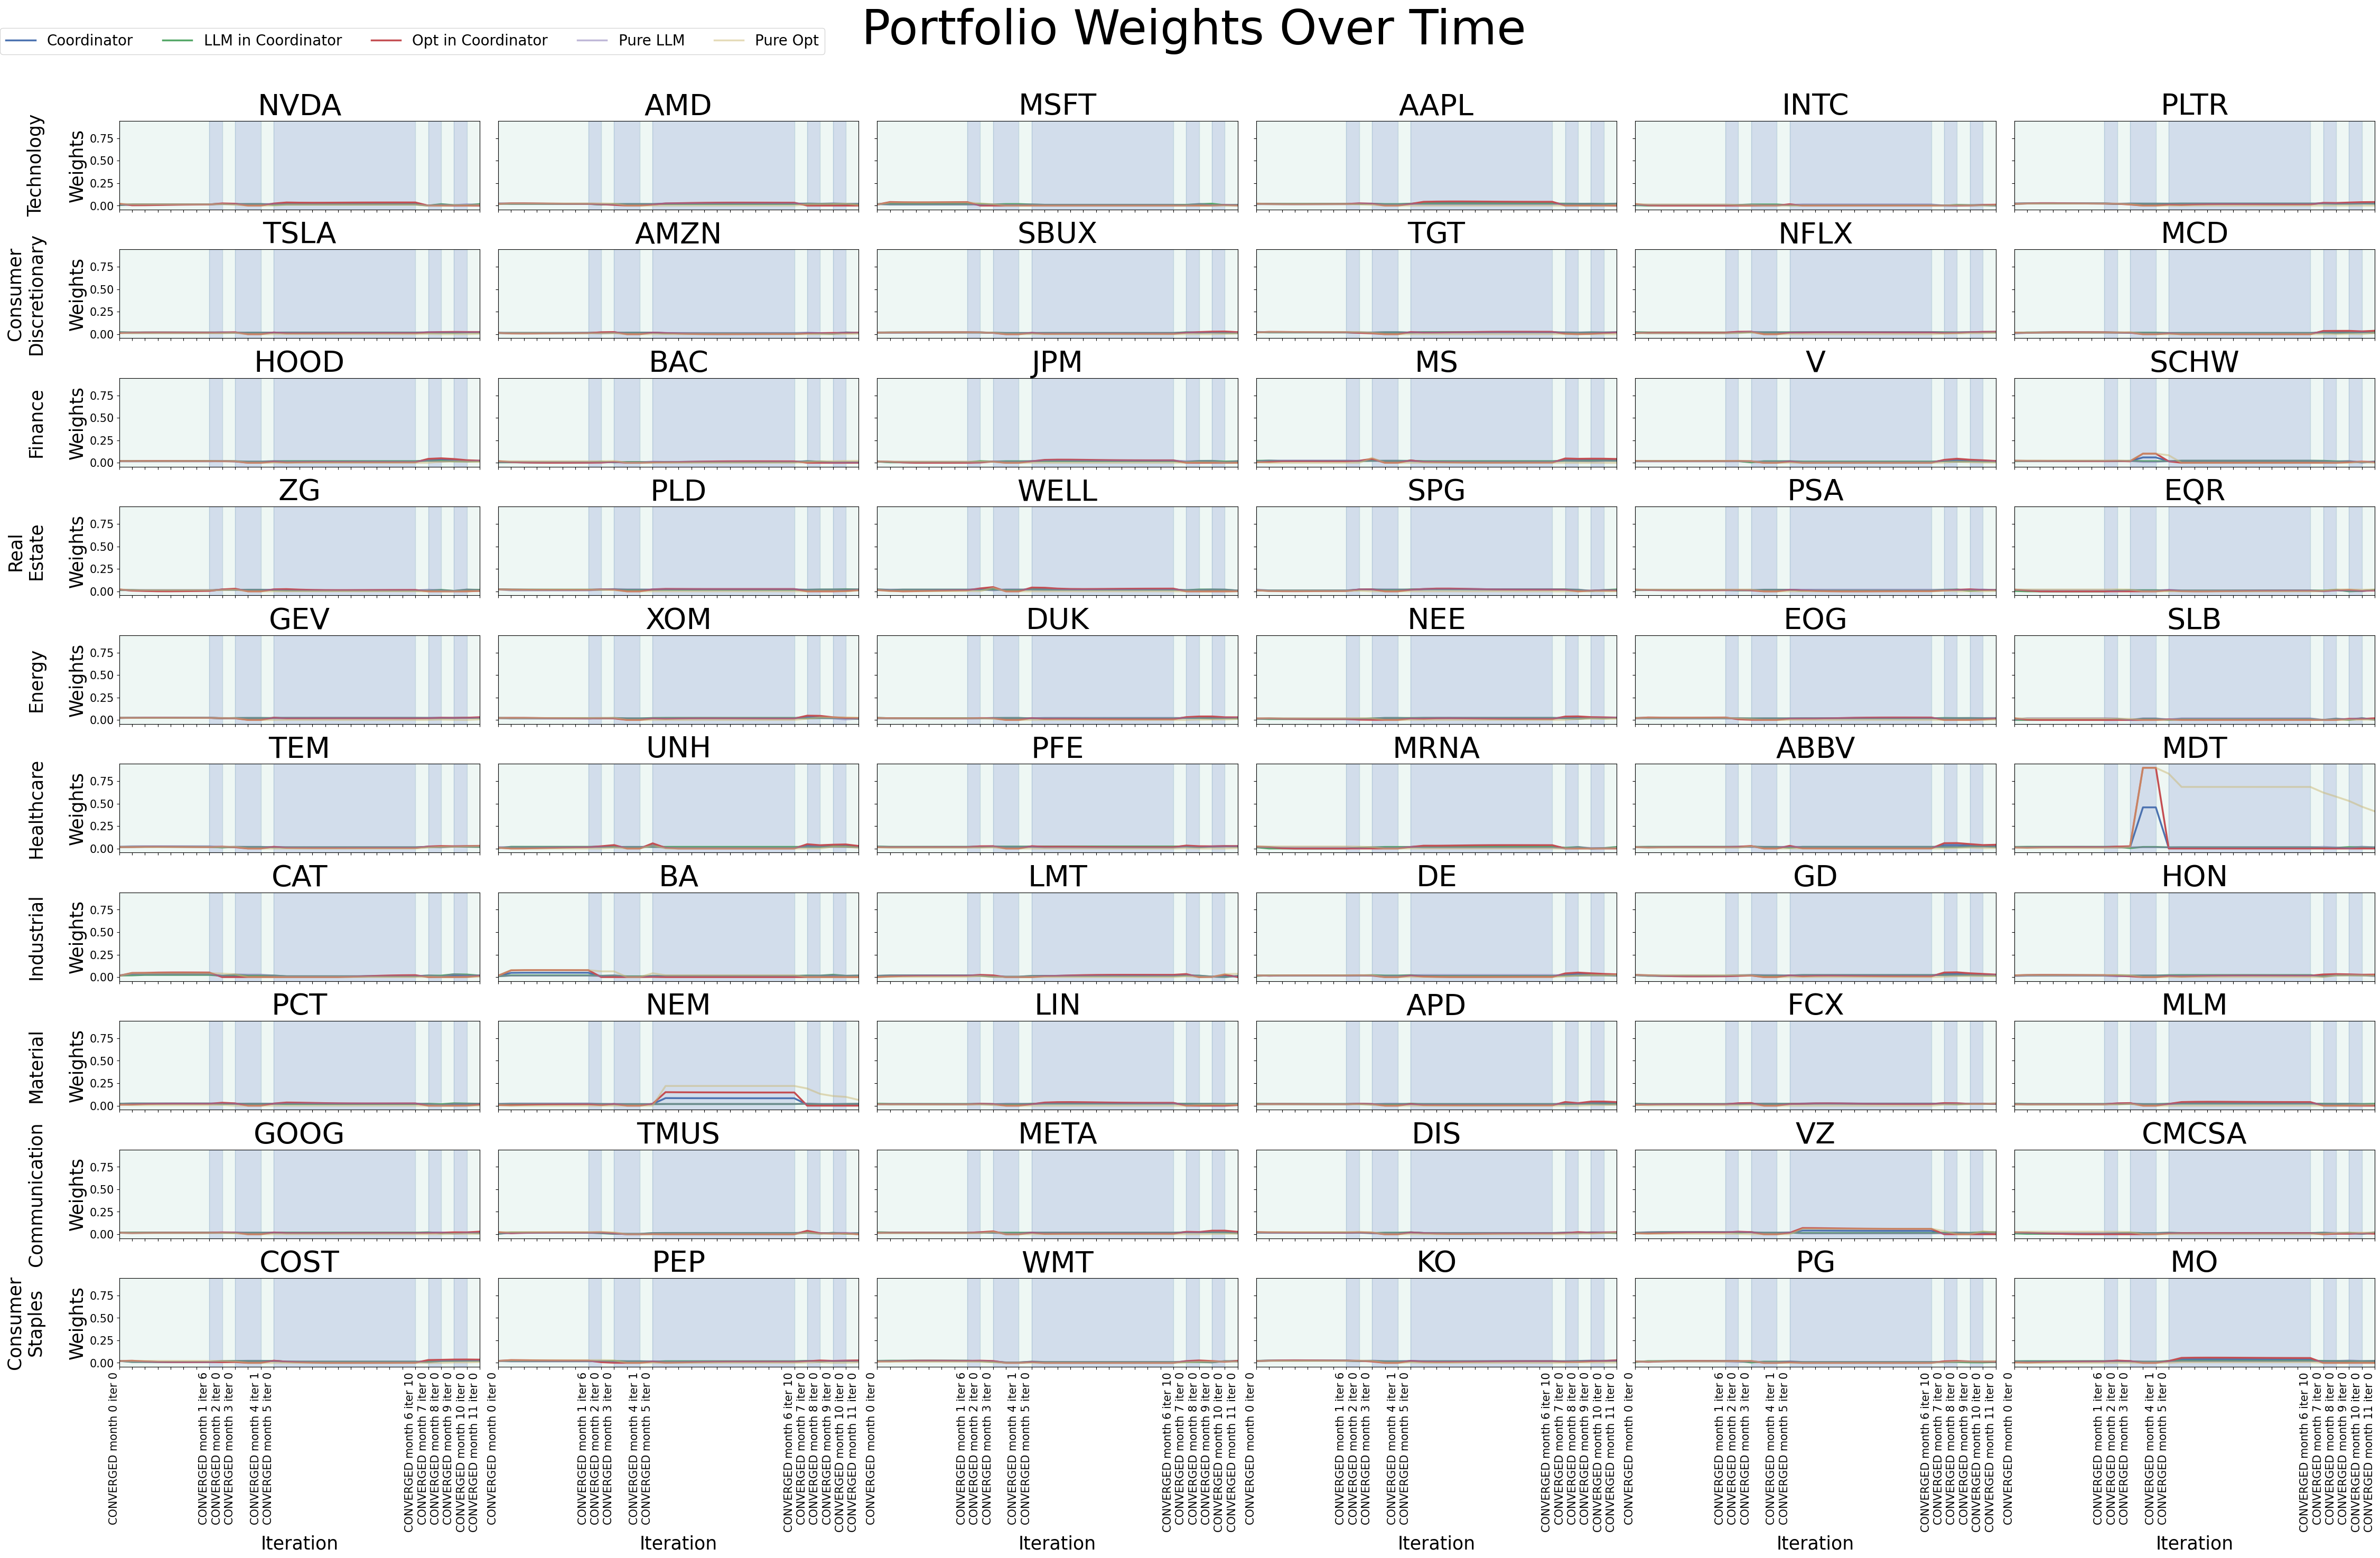

In [315]:
rows = 10
columns = 6

fig, axes = plt.subplots(rows, columns, figsize=(45, 30), sharey=True)
fig.suptitle("Portfolio Weights Over Time\n", fontsize=65)
plt.subplots_adjust(top=0.6)  

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
blue_region = (round(108/255, 2), round(143/255, 2), round(191/255, 2), 0.3)
green_region = (round(201/255, 2), round(230/255, 2), round(219/255, 2), 0.3)

days = []
prev = 0

for i, log in enumerate(df['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

# Generate x-tick labels, hiding those without "CONVERGED"
xtick_labels = []
for status in df['status']:
    if "CONVERGED" in status:
        xtick_labels.append(status)
    else:
        xtick_labels.append("")  # Blank label for non-CONVERGED iterations

for i in range(rows * columns):

    isEmpty = False

    try:
        ticker = tickers[i]
    except:
        ticker = None
        isEmpty = True
    
    # Fill regions
    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    if ticker:
        # Plot lines
        if i == 0:
            axes[i].plot(df['status'], df[f'all {ticker}'], label='Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], df[f'llm {ticker}'], label='LLM in Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], df[f'opt {ticker}'], label='Opt in Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], pure_llm_history[i], label='Pure LLM', linewidth=2.5, alpha=0.5)
            axes[i].plot(df['status'], pure_opt_history[i], label='Pure Opt', linewidth=2.5, alpha=0.5)
        else:
            axes[i].plot(df['status'], df[f'all {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], df[f'llm {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], df[f'opt {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], pure_llm_history[i], linewidth=2.5, alpha=0.5)
            axes[i].plot(df['status'], pure_opt_history[i], linewidth=2.5, alpha=0.5)
        
        # Title and tick parameters
        axes[i].set_title(f'{ticker}', fontsize=40)

    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

    # Set x-tick labels with filtered labels
    axes[i].set_xticks(range(len(df['status'])))
    axes[i].set_xticklabels(xtick_labels, fontsize=15, ha='right')
    
    # X-axis limit
    axes[i].set_xlim(0, len(df['status']) - 1)

    
    # Y-label on first column
    if i in [i for i in range(0, rows*columns, columns)]:
        cat = '\n'.join(stock_categories[i//columns].split())
        axes[i].set_ylabel(f"{cat}\n\nWeights", fontsize=25)
    
    # X-label only on last row
    if i in [i for i in range(rows*columns-columns, rows*columns)]:
        axes[i].set_xlabel("Iteration", fontsize=25)
    else:
        # Hide x-tick labels for the first two rows
        axes[i].tick_params(axis='x', labelbottom=False)

# Add common legend (adjust location as you like)
# fig.legend(loc=(0.00, 0.95), ncol=2, fontsize=20)
fig.legend(loc=(0.00, 0.965), ncol=5, fontsize=20)

plt.tight_layout()

plt.savefig(grid_image_path, dpi=300) # , bbox_inches='tight'  
plt.show()

#### Backtesting
Seeing how the strategies perform based on historical data

In [316]:
# get the beginning price for each month
df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)
df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)

In [317]:
def backtest(df, columns=None, weights_=None):
    i = 0

    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]

    while i < 11:
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # 2. -> buy jan 31
        shares = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            shares_bought = initial_capital * weights[j] / ticker_price
            shares.append(shares_bought)
            portfolio_value -= shares_bought * ticker_price
            # print(f"{weights[j] = }\t{ticker_price = } -> {shares_bought = }")

        # 3. -> sell feb 31
        i += 1
        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            portfolio_value += shares[j] * ticker_price

        portfolio_history.append(portfolio_value)

    print(portfolio_value)
    return portfolio_history

all_weights = ["all " + ticker for ticker in tickers]

portfolio_history_coordinated = backtest(df_end, columns=all_weights)
portfolio_history_opt = backtest(df_init, weights_=opt_histories)
portfolio_history_llm = backtest(df_init, weights_=llm_histories)

14011.88631302349
13919.240097638316
13478.13289286722


#### Plot the backtesting

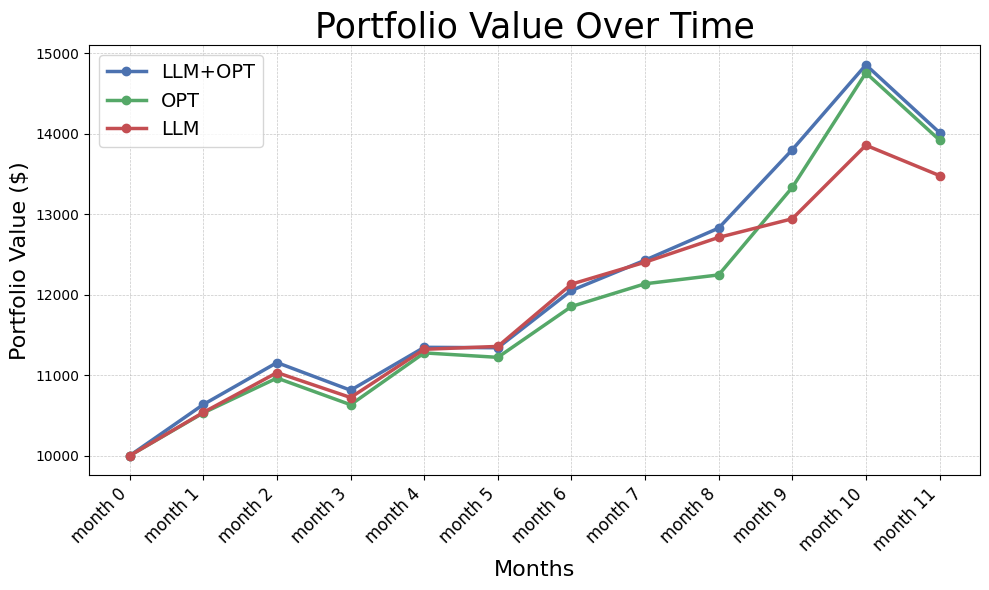

In [318]:
# Create labels for months 0 through 11
months = [f"month {i}" for i in range(12)]

plt.figure(figsize=(10, 6))

# Plot as a line chart with markers
plt.plot(months, portfolio_history_coordinated, linestyle='-', marker='o', linewidth=2.5, label='LLM+OPT')
plt.plot(months, portfolio_history_opt, linestyle='-', marker='o', linewidth=2.5, label='OPT')
plt.plot(months, portfolio_history_llm, linestyle='-', marker='o', linewidth=2.5, label='LLM')

# Add a title, axis labels, and grid
plt.title("Portfolio Value Over Time", fontsize=25)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Portfolio Value ($)", fontsize=16)

# Improve grid styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with larger font size
plt.legend(fontsize=14, loc='upper left')

# Rotate x-tick labels and align them to the right
plt.xticks(fontsize=12, rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.savefig(pft_value_over_time_path, dpi=500, bbox_inches='tight')  
plt.show()

#### Heat Map

In [319]:
# only get the coordination results
df_filtered_all = df_filtered.loc[:, df_filtered.columns.str.contains(r'\ball\b', case=False)]

# get average
mean_values = df_filtered_all.mean()
df_filtered_ticker_name = pd.DataFrame([mean_values])
df_filtered_ticker_name.reset_index(drop=True, inplace=True)

# drop all from column headers
df_filtered_ticker_name.columns = df_filtered_ticker_name.columns.str.replace(r'^all ', '', regex=True)

df_filtered_ticker_name

,NVDA,AMD,MSFT,AAPL,INTC,PLTR,TSLA,AMZN,SBUX,TGT,NFLX,MCD,HOOD,BAC,JPM,MS,V,SCHW,ZG,PLD,WELL,SPG,PSA,EQR,GEV,XOM,DUK,NEE,EOG,SLB,TEM,UNH,PFE,MRNA,ABBV,MDT,CAT,BA,LMT,DE,GD,HON,PCT,NEM,LIN,APD,FCX,MLM,GOOG,TMUS,META,DIS,VZ,CMCSA,COST,PEP,WMT,KO,PG,MO
0,0.01138,0.013627,0.009171,0.016302,0.004857,0.022051,0.018145,0.01354,0.017113,0.016237,0.019972,0.018845,0.020188,0.005903,0.010759,0.024678,0.017938,0.017719,0.011849,0.015788,0.016577,0.014326,0.01348,0.007889,0.021051,0.020886,0.021044,0.017906,0.014344,0.005493,0.017725,0.022829,0.021237,0.008896,0.023938,0.04726,0.014144,0.011732,0.011848,0.021137,0.022282,0.019106,0.017075,0.018054,0.015247,0.02189,0.020127,0.016339,0.0174,0.011369,0.020549,0.017272,0.015973,0.009248,0.019464,0.01777,0.014759,0.018952,0.011744,0.015575


In [320]:
llm_histories_np_array = np.array(llm_histories)
df_llm_histories = pd.DataFrame(llm_histories_np_array, columns=tickers)
mean_llm_values = df_llm_histories.mean()
df_llm_histories_mean = pd.DataFrame([mean_llm_values])
df_llm_histories_mean.reset_index(drop=True, inplace=True)

df_llm_histories_mean

,NVDA,AMD,MSFT,AAPL,INTC,PLTR,TSLA,AMZN,SBUX,TGT,NFLX,MCD,HOOD,BAC,JPM,MS,V,SCHW,ZG,PLD,WELL,SPG,PSA,EQR,GEV,XOM,DUK,NEE,EOG,SLB,TEM,UNH,PFE,MRNA,ABBV,MDT,CAT,BA,LMT,DE,GD,HON,PCT,NEM,LIN,APD,FCX,MLM,GOOG,TMUS,META,DIS,VZ,CMCSA,COST,PEP,WMT,KO,PG,MO
0,0.011998,0.020907,0.010451,0.017948,0.005932,0.022821,0.019565,0.014571,0.01607,0.021223,0.02036,0.014515,0.017246,0.008498,0.015629,0.019946,0.014929,0.016485,0.014865,0.020727,0.017696,0.017449,0.016522,0.010535,0.021601,0.017112,0.019147,0.018083,0.018734,0.010041,0.018647,0.015993,0.017781,0.010502,0.018018,0.01382,0.020813,0.014582,0.011943,0.017647,0.020781,0.01496,0.020551,0.020826,0.019167,0.017574,0.020362,0.018801,0.015926,0.0114,0.016876,0.016143,0.01826,0.015157,0.017968,0.017349,0.014147,0.021653,0.012669,0.018079


In [321]:
opt_histories_np_array = np.array(opt_histories)
df_opt_histories = pd.DataFrame(opt_histories_np_array, columns=tickers)
mean_opt_values = df_opt_histories.mean()
df_opt_histories_mean = pd.DataFrame([mean_opt_values])
df_opt_histories_mean.reset_index(drop=True, inplace=True)

df_opt_histories_mean

,NVDA,AMD,MSFT,AAPL,INTC,PLTR,TSLA,AMZN,SBUX,TGT,NFLX,MCD,HOOD,BAC,JPM,MS,V,SCHW,ZG,PLD,WELL,SPG,PSA,EQR,GEV,XOM,DUK,NEE,EOG,SLB,TEM,UNH,PFE,MRNA,ABBV,MDT,CAT,BA,LMT,DE,GD,HON,PCT,NEM,LIN,APD,FCX,MLM,GOOG,TMUS,META,DIS,VZ,CMCSA,COST,PEP,WMT,KO,PG,MO
0,0.006537,0.013607,0.007173,0.005105,0.004846,0.006524,0.004564,0.003999,0.007178,0.006785,0.008386,0.007394,0.010067,0.012884,0.005124,0.005047,0.008613,0.024159,0.006145,0.006985,0.0049,0.00198,0.007475,0.013779,0.008036,0.017736,0.007944,0.010289,0.005741,0.005324,0.013949,0.008175,0.00419,0.007191,0.006663,0.422412,0.011348,0.023727,0.008114,0.01445,0.011405,0.013356,0.00216,0.068093,0.0068,0.006226,0.009071,0.006378,0.00537,0.010649,0.006518,0.011306,0.013951,0.014432,0.007926,0.010475,0.008791,0.009343,0.012039,0.001166


In [322]:
df_mean_total = pd.concat([df_filtered_ticker_name, df_llm_histories_mean, df_opt_histories_mean], axis=0, ignore_index=True)

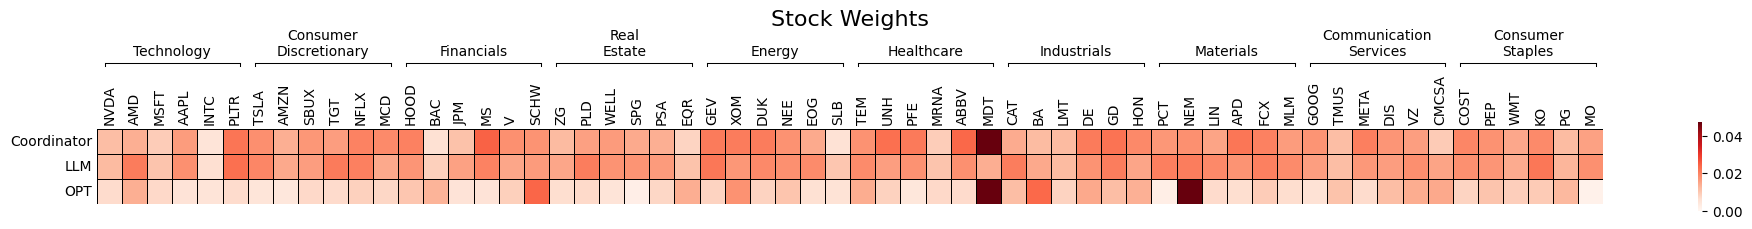

In [323]:
import seaborn as sns

plt.figure(figsize=(20, 2))  # Adjust the figure size for better visualization
ax = sns.heatmap(
    df_mean_total, 
    cmap="Reds", 
    linewidths=0.5, 
    linecolor="black", 
    annot=False, 
    cbar=True, 
    square=True,
    xticklabels=True,
    yticklabels=["Coordinator", "LLM", "OPT"],
    vmin=0, 
    vmax=np.max(df_mean_total.iloc[0].tolist())  # Scale from 0 to max value in the data
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.tick_params(axis="both", length=0)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tick_params(axis="x", top=True, labeltop=True, labelbottom=False)
plt.xlabel(None)
plt.ylabel(None)

categories = [
    'Technology',
    'Consumer Discretionary',
    'Financials',
    'Real Estate',
    'Energy',
    'Healthcare',
    'Industrials',
    'Materials',
    'Communication Services',
    'Consumer Staples'
]

# Vertical/horizontal offsets for the bracket
y_top = 1.88
y_bottom = 1.83
margin = 0.3  # how much to pull in from each side so brackets don't overlap
linewidth = 0.75

for i, cat in enumerate(categories):
    x_left = i * 6 + margin
    x_right = (i + 1) * 6 - margin

    # Left vertical line
    ax.plot([x_left, x_left], [y_bottom, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Right vertical line
    ax.plot([x_right, x_right], [y_bottom, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Horizontal top line
    ax.plot([x_left, x_right], [y_top, y_top],
            color="black", lw=linewidth, transform=ax.get_xaxis_transform(), clip_on=False)
    # Category label
    ax.text((x_left + x_right) / 2, y_top + 0.05, '\n'.join(cat.split())+'',
            ha="center", va="bottom", transform=ax.get_xaxis_transform(), fontsize=10)

plt.title("Stock Weights", fontsize=16, pad=35)
plt.tight_layout()

plt.savefig(heatmap_path, dpi=500, bbox_inches='tight')  
plt.show()